<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Natural Language Processing (NLP)
## *Data Science Unit 4 Sprint 1 Assignment 1*

Your goal in assignment: find the attributes of the best & worst coffee shops in the dataset. The text is fairly raw: dates in the review, extra words in the `star_rating` column, etc. You'll probably want to clean that stuff up for a better analysis. 

Analyze the corpus of text using text visualizations of token frequency. Try cleaning the data as much as possible. Try the following techniques: 
- Lemmatization
- Custom stopword removal

Keep in mind the attributes of good tokens. Once you have a solid baseline, layer in the star rating in your visualization(s). Keep part in this assignment - produce a write-up of the attributes of the best and worst coffee shops. Based on your analysis, what makes the best the best and the worst the worst. Use graphs and numbesr from your analysis to support your conclusions. There should be plenty of markdown cells! :coffee:

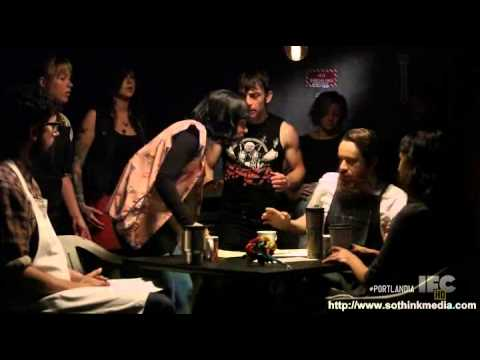

In [97]:
from IPython.display import YouTubeVideo

YouTubeVideo('Jml7NVYm8cs')

In [110]:
import pandas as pd
shops = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-1-NLP/master/module1-text-data/data/yelp_coffeeshop_review_data.csv'
shop = pd.read_csv(shops)
shop.head()

,coffee_shop_name,full_review_text,star_rating
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5.0 star rating
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4.0 star rating
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4.0 star rating
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2.0 star rating
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4.0 star rating


In [8]:
pip install squarify

In [9]:
pip install spacy 

In [0]:
 """
Import Statements
"""

# Base
from collections import Counter
import re

import pandas as pd

# Plotting
import squarify
import matplotlib.pyplot as plt
import seaborn as sns

# NLP Libraries
import spacy
from spacy.tokenizer import Tokenizer
from nltk.stem import PorterStemmer

nlp = spacy.load("en_core_web_sm")


In [0]:
# Base
from collections import Counter
import re

In [0]:
# Plotting
import squarify
import matplotlib.pyplot as plt
import seaborn as sns


In [0]:
import pandas as pd


In [0]:
# NLP Libraries
import spacy
from spacy.tokenizer import Tokenizer
from nltk.stem import PorterStemmer 
nlp = spacy.load("en_core_web_sm")


In [15]:
pip install squarify

In [16]:
pip install spacy

In [17]:
shop[:50]

,coffee_shop_name,full_review_text,star_rating
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5.0 star rating
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4.0 star rating
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4.0 star rating
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2.0 star rating
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4.0 star rating
5,The Factory - Cafe With a Soul,11/20/2016 1 check-in Very cute cafe! I think...,4.0 star rating
6,The Factory - Cafe With a Soul,"10/27/2016 2 check-ins Listed in ""Nuptial Cof...",4.0 star rating
7,The Factory - Cafe With a Soul,11/2/2016 2 check-ins Love this place! 5 sta...,5.0 star rating
8,The Factory - Cafe With a Soul,"10/25/2016 1 check-in Ok, let's try this appr...",3.0 star rating
9,The Factory - Cafe With a Soul,11/10/2016 3 check-ins This place has been sh...,5.0 star rating


In [31]:
shop['full_review_text'][:50].value_counts()

 11/11/2016 I never write Yelp reviews, ever. But when I walked in here it felt like I was in a hipster Alice in wonderland. The decor is spot on and they left no details out. The Marymint Monroe is really amazing and the chicken and waffle is really good. The staff is so wonderful too, you could tell they really love what they're doing. The swings are a nice touch too!                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

In [0]:
import string
shop.full_review_text = shop.full_review_text.apply(lambda x: x.lower())
shop.full_review_text = shop.full_review_text.apply(lambda x: x.translate(string.digits))

## Stretch Goals

* Analyze another corpus of documents - such as Indeed.com job listings ;).
* Play the the Spacy API to
 - Extract Named Entities
 - Extracting 'noun chunks'
 - Attempt Document Classification with just Spacy
 - *Note:* This [course](https://course.spacy.io/) will be of interesting in helping you with these stretch goals. 
* Try to build a plotly dash app with your text data 



In [0]:
shop.full_review_text = shop.full_review_text.apply(lambda x: x.lower())


In [0]:
shop[['full_review_text']]

In [0]:
import string
shop.full_review_text = shop.full_review_text.apply(lambda x: x.translate(string.punctuation))

In [0]:
shop.full_review_text = shop.full_review_text.apply(lambda x: x.translate(string.digits))

In [0]:
shop.full_review_text.head()

In [0]:
shop.full_review_text.dtypes

In [0]:
shop.full_review_text

In [0]:
# import string library function  
import string  
    
# An input string. 
Sentence = shop['full_review_text']
  
for i in Sentence: 
      
    # checking wheather the char is punctuation. 
    if i in string.punctuation: 
      print(i)
   

In [32]:
shop['full_review_text']

0        11/25/2016 1 check-in Love love loved the atm...
1        12/2/2016 Listed in Date Night: Austin, Ambia...
2        11/30/2016 1 check-in Listed in Brunch Spots ...
3        11/25/2016 Very cool decor! Good drinks Nice ...
4        12/3/2016 1 check-in They are located within ...
5        11/20/2016 1 check-in Very cute cafe! I think...
6        10/27/2016 2 check-ins Listed in "Nuptial Cof...
7        11/2/2016 2 check-ins Love this place!  5 sta...
8        10/25/2016 1 check-in Ok, let's try this appr...
9        11/10/2016 3 check-ins This place has been sh...
10       10/22/2016 1 check-in Listed in Americano Thi...
11       11/20/2016 The store has A+ decoration, but h...
12       11/17/2016 1 check-in Listed in 2016 - The Th...
13       12/5/2016 This is such a cute little cafe! I'...
14       11/13/2016 Beautiful eccentric coffee shop wi...
15       11/9/2016 1 check-in Listed in In Search of F...
16       11/6/2016 Really love the atmosphere here! I ...
17       10/25

In [0]:
x = txt.split("#")

In [0]:
txt = "apple#banana#cherry#orange"

x = txt.split("#")

print(x)

In [0]:
['apple', 'banana', 'cherry', 'orange']

In [0]:
sh

In [0]:
shop.full_review_text

In [0]:
[]
for i in shop.full_review_text:
  i[5:].append()

In [0]:
sample = "Friends, Romans, countrymen, lend me your ears;"

In [0]:
sample.split()

In [0]:
 sample+" 007 911"

In [0]:
import re

re.sub(r'[^a-zA-Z ^0-9]', '', sample+" 911")

In [0]:
def tokenize(text):
    """Parses a string into a list of semantic units (words)

    Args:
        text (str): The string that the function will tokenize.

    Returns:
        list: tokens parsed out by the mechanics of your choice
    """
    
    tokens = re.sub(r'[^a-zA-Z ^]', '', text)
    tokens = tokens.lower().split()
    
    return tokens
 

In [0]:
shop.full_review_text = shop.full_review_text.apply(tokenize)

In [35]:
shop.full_review_text.head()

0    [checkin, love, love, loved, the, atmosphere, ...
1    [listed, in, date, night, austin, ambiance, in...
2    [checkin, listed, in, brunch, spots, i, loved,...
3    [very, cool, decor, good, drinks, nice, seatin...
4    [checkin, they, are, located, within, the, nor...
Name: full_review_text, dtype: object

,coffee_shop_name,full_review_text,star_rating
0,The Factory - Cafe With a Soul,"[checkin, love, love, loved, the, atmosphere, ...",5.0 star rating
1,The Factory - Cafe With a Soul,"[listed, in, date, night, austin, ambiance, in...",4.0 star rating
2,The Factory - Cafe With a Soul,"[checkin, listed, in, brunch, spots, i, loved,...",4.0 star rating
3,The Factory - Cafe With a Soul,"[very, cool, decor, good, drinks, nice, seatin...",2.0 star rating
4,The Factory - Cafe With a Soul,"[checkin, they, are, located, within, the, nor...",4.0 star rating
5,The Factory - Cafe With a Soul,"[checkin, very, cute, cafe, i, think, from, th...",4.0 star rating
6,The Factory - Cafe With a Soul,"[checkins, listed, in, nuptial, coffee, bliss,...",4.0 star rating
7,The Factory - Cafe With a Soul,"[checkins, love, this, place, stars, for, clea...",5.0 star rating
8,The Factory - Cafe With a Soul,"[checkin, ok, lets, try, this, approach, pros,...",3.0 star rating
9,The Factory - Cafe With a Soul,"[checkins, this, place, has, been, shown, on, ...",5.0 star rating


In [40]:
pip install collections

  ERROR: Could not find a version that satisfies the requirement collections (from versions: none)
ERROR: No matching distribution found for collections


In [0]:
# Object from Base Python

from collections import Counter
word_counts = Counter()

In [47]:


shop['full_review_text'].apply(lambda x: word_counts.update(x))


0       None
1       None
2       None
3       None
4       None
5       None
6       None
7       None
8       None
9       None
10      None
11      None
12      None
13      None
14      None
15      None
16      None
17      None
18      None
19      None
20      None
21      None
22      None
23      None
24      None
25      None
26      None
27      None
28      None
29      None
        ... 
7586    None
7587    None
7588    None
7589    None
7590    None
7591    None
7592    None
7593    None
7594    None
7595    None
7596    None
7597    None
7598    None
7599    None
7600    None
7601    None
7602    None
7603    None
7604    None
7605    None
7606    None
7607    None
7608    None
7609    None
7610    None
7611    None
7612    None
7613    None
7614    None
7615    None
Name: full_review_text, Length: 7616, dtype: object

In [48]:
#update it based on a split of each of our documents
word_counts.most_common(10)


[('the', 69618),
 ('and', 53302),
 ('a', 45512),
 ('i', 40498),
 ('to', 34328),
 ('of', 25200),
 ('is', 23998),
 ('coffee', 20708),
 ('was', 19414),
 ('in', 19092)]

In [0]:
def count(docs):

        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')

In [0]:
wc = count(shop['full_review_text'])


In [51]:
wc.head()

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
68,the,6847,34809,1.0,0.045411,0.045411,0.899028
6,and,6864,26651,2.0,0.034768,0.080180,0.901261
44,a,6246,22756,3.0,0.029687,0.109867,0.820116
26,i,5532,20249,4.0,0.026416,0.136283,0.726366
45,to,5653,17164,5.0,0.022392,0.158675,0.742253


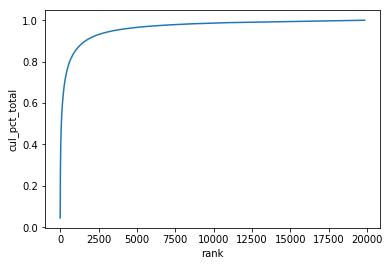

In [52]:
import seaborn as sns

# Cumulative Distribution Plot
sns.lineplot(x='rank', y='cul_pct_total', data=wc);

In [53]:
wc[wc['rank'] <= 20]['cul_pct_total'].max()


0.31714651370006874

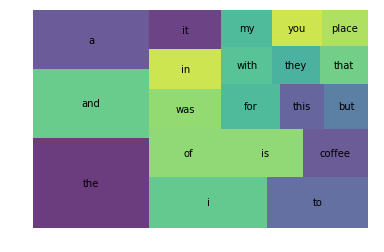

In [54]:
import squarify
import matplotlib.pyplot as plt
wc_top20 = wc[wc['rank'] <=20]

squarify.plot(sizes = wc_top20)

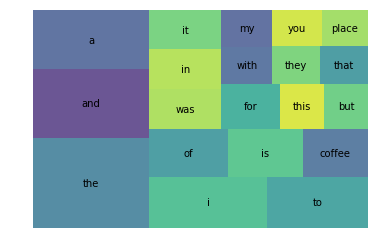

In [0]:
import spacy 

In [0]:
from spacy.tokenizer import Tokenizer

In [0]:
nlp = spacy.load('en')

In [0]:
#tokenizer
tokenizer = Tokenizer(nlp.vocab)

In [63]:
#print out a list of tokens


TypeError: ignored

In [0]:
tokens = []

In [0]:
for doc in tokenizer.pipe(shop['full_review_text'], batch_size=500):
    doc_tokens = [token.text for token in doc]
    tokens.append(doc_tokens)

shop['full_review_text'] = tokens

In [67]:
shop['full_review_text'].head()

0    [ , 11/25/2016, 1, check-in, Love, love, loved...
1    [ , 12/2/2016, Listed, in, Date, Night:, Austi...
2    [ , 11/30/2016, 1, check-in, Listed, in, Brunc...
3    [ , 11/25/2016, Very, cool, decor!, Good, drin...
4    [ , 12/3/2016, 1, check-in, They, are, located...
Name: full_review_text, dtype: object

In [0]:
wc = count(shop['full_review_text'])


In [69]:
wc.head()

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
73,the,6520,27779,1.0,0.034334,0.034334,0.856092
9,and,6804,25748,2.0,0.031824,0.066157,0.893382
6,,7616,22606,3.0,0.027940,0.094097,1.000000
51,a,6181,22085,4.0,0.027296,0.121394,0.811581
63,I,5469,19780,5.0,0.024447,0.145841,0.718093


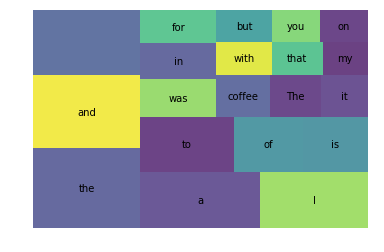

In [70]:
wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

In [71]:
len(nlp.Defaults.stop_words)


326

In [74]:
tokens = []

""" Update those tokens w/o stopwords"""
for doc in tokenizer.pipe(shop['full_review_text'], batch_size=500):
    
    doc_tokens = []
    
    for token in doc:
        if (token.is_stop == False) & (token.is_punct == False):
            doc_tokens.append(token.text.lower())

    tokens.append(doc_tokens)

shop['full_review_text'] = tokens

TypeError: ignored

In [0]:
STOP_WORDS = nlp.Defaults.stop_words.union(['I', 'amazon', 'i', 'Amazon', 'it', "it's", 'it.', 'the', 'this', ' ', 'place', 'the', '', 'they'])

In [102]:
STOP_WORDS

{'',
 ' ',
 "'d",
 "'ll",
 "'m",
 "'re",
 "'s",
 "'ve",
 'Amazon',
 'I',
 'a',
 'about',
 'above',
 'across',
 'after',
 'afterwards',
 'again',
 'against',
 'all',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'am',
 'amazon',
 'among',
 'amongst',
 'amount',
 'an',
 'and',
 'another',
 'any',
 'anyhow',
 'anyone',
 'anything',
 'anyway',
 'anywhere',
 'are',
 'around',
 'as',
 'at',
 'back',
 'be',
 'became',
 'because',
 'become',
 'becomes',
 'becoming',
 'been',
 'before',
 'beforehand',
 'behind',
 'being',
 'below',
 'beside',
 'besides',
 'between',
 'beyond',
 'both',
 'bottom',
 'but',
 'by',
 'ca',
 'call',
 'can',
 'cannot',
 'could',
 'did',
 'do',
 'does',
 'doing',
 'done',
 'down',
 'due',
 'during',
 'each',
 'eight',
 'either',
 'eleven',
 'else',
 'elsewhere',
 'empty',
 'enough',
 'even',
 'ever',
 'every',
 'everyone',
 'everything',
 'everywhere',
 'except',
 'few',
 'fifteen',
 'fifty',
 'first',
 'five',
 'for',
 'former',
 'former

In [0]:
tokens = []

for doc in tokenizer.pipe(shop['full_review_text'], batch_size=500):
    
    doc_tokens = []
    
    for token in doc: 
        if token.text not in STOP_WORDS:
            doc_tokens.append(token.text.lower())
   
    tokens.append(doc_tokens)
    
shop['full_review_text'] = tokens

In [104]:
wc = count(shop['full_review_text'])
wc.head()

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
15,coffee,4210,8058,1.0,0.018906,0.018906,0.552784
89,the,3936,6870,2.0,0.016119,0.035025,0.516807
119,great,2438,3250,3.0,0.007625,0.042650,0.320116
189,like,2034,2902,4.0,0.006809,0.049459,0.267069
200,good,2084,2779,5.0,0.006520,0.055979,0.273634


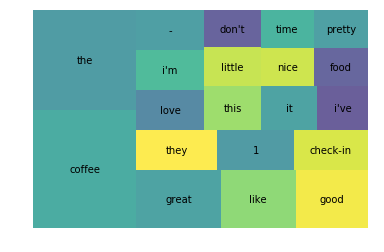

In [105]:
wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

wc = count(df['tokens'])
wc.head()

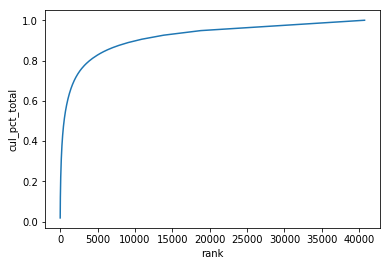

In [106]:
sns.lineplot(x='rank', y='cul_pct_total', data=wc);


In [0]:
def get_lemmas(text):

    lemmas = []
    
    doc = nlp(text)
    
    # Something goes here :P
    for token in doc: 
        if ((token.is_stop == False) and (token.is_punct == False)) and (token.pos_!= 'PRON'):
            lemmas.append(token.lemma_)
    
    return lemmas

In [0]:
shop['full_review_text'] = shop['full_review_text'].apply(get_lemmas)


In [113]:
shop['full_review_text'].head()

0    [ , 11/25/2016, 1, check, love, love, love, at...
1    [ , 12/2/2016, list, Date, Night, Austin, Ambi...
2    [ , 11/30/2016, 1, check, Listed, Brunch, Spot...
3    [ , 11/25/2016, cool, decor, good, drink, nice...
4    [ , 12/3/2016, 1, check, locate, Northcross, m...
Name: full_review_text, dtype: object

In [0]:
wc = count(shop['full_review_text'])


In [115]:
wc.head()

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
4,,7616,22606,1.0,0.057554,0.057554,1.000000
12,coffee,4800,10053,2.0,0.025594,0.083148,0.630252
80,place,3869,6007,3.0,0.015294,0.098442,0.508009
169,good,3561,5299,4.0,0.013491,0.111933,0.467568
112,great,2833,3894,5.0,0.009914,0.121847,0.371980


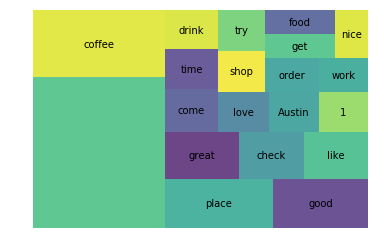

In [116]:
wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()